# Cell type annotation prediction

Run this notebook on google colab to use a free GPU!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Cell-Type-Annotation.ipynb)

In this notebook, we aim to predict cell type annotations based on gene expression profiles using Foundation Models. 

Following a tutorial from [scGPT](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), we will:

* Use the pre-trained scGPT model to generate embeddings from gene expression profiles.
* Train a smaller neural network on these embeddings to predict cell types, rather than fine-tuning the entire scGPT model.

Comparison with [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D):
* We will apply the same approach to another Foundation Model, Geneformer, and compare the prediction results from both models to evaluate their performance.

This approach significantly reduces the time and computational resources required, making it more efficient while still achieving reliable predictions.

### Installing required packages and importing libraries

In [1]:
!pip install tensorflow_addons
!pip install git+https://github.com/helicalAI/helical.git@main | tail -n 1

  Running command git clone --filter=blob:none --quiet https://github.com/helicalAI/helical.git /private/var/folders/dl/jdlpx0rd1sngyrhc_xk9zmdw0000gn/T/pip-req-build-to1qs2ry
  Running command git checkout -b main --track origin/main
  Switched to a new branch 'main'
  branch 'main' set up to track 'origin/main'.


In [2]:
!pip install tensorboard

In [3]:
# %load_ext tensorboard # uncomment to use tensorboard

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from tensorflow_addons.metrics import F1Score
import os
import requests
import numpy as np
import scanpy as sc
import torch

from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0-rc1 and is not supported. 
Some things might work, some t

### Downloading the training and evaluation sets

To build and assess the performance of our machine learning models, we need to work with two types of datasets: a training set and an evaluation set.

- **Training set**  `c_data.h5ad`: This dataset is used to train the model. During training, the model learns to understand the patterns and relationships within the data, allowing it to make predictions.
- **Evaluation set**  `ms_default.h5ad`: This dataset is used to evaluate the model's performance. It helps us understand how well the model generalizes to new, unseen data by providing an unbiased assessment of its predictive capabilities.

Following the methodology from a [paper](https://www.biorxiv.org/content/10.1101/2023.10.24.563625v1) comparing scGPT and Geneformer, we will download these datasets. The evaluation set was retrieved from their [Google Drive](https://drive.google.com/drive/folders/1bNOrB0ukkAuGtcocdvctSVOaAUG6uJ8l), and the training set was obtained from scGPT [here](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v).


In [5]:
def download_files(files: list[str])-> None:

    for filename in files:
        url = f"https://helicalpackage.blob.core.windows.net/helicalpackage/data/{filename}"

        # Check if the file already exists in the current directory
        if os.path.exists(filename):
            print(f"Files already exist. Skipping downloads.")
        else:
            response = requests.get(url)
            if response.status_code == 200:
                with open(filename, "wb") as file:
                    file.write(response.content)
                print(f"Downloaded {filename} successfully.")
            else:
                print(f"Failed to download {filename}.")

In [6]:
files = ["c_data.h5ad", "ms_default.h5ad"]
download_files(files)

Files already exist. Skipping downloads.
Files already exist. Skipping downloads.


### Familiarizing ourselves with the data


Before we start training our models, it's important to understand the structure of our data. We are particularly interested in the names of the cell types we want to predict, which are saved in `adata.obs["celltype"]`.

Additionally, we need to determine the number of distinct cell types present in our dataset. This information is needed for setting up our model correctly, and for downstream evaluation metrics calculation.

In [7]:
adata = sc.read("c_data.h5ad")

# get labels: the celltype
num_types = adata.obs["celltype"].unique().shape[0]
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["celltype"].tolist())

This is all summarized in this dictionary:

In [8]:
id2type

{0: 'PVALB-expressing interneuron',
 1: 'SST-expressing interneuron',
 2: 'SV2C-expressing interneuron',
 3: 'VIP-expressing interneuron',
 4: 'astrocyte',
 5: 'cortical layer 2-3 excitatory neuron A',
 6: 'cortical layer 2-3 excitatory neuron B',
 7: 'cortical layer 4 excitatory neuron',
 8: 'cortical layer 5-6 excitatory neuron',
 9: 'endothelial cell',
 10: 'microglial cell',
 11: 'mixed excitatory neuron',
 12: 'mixed glial cell?',
 13: 'oligodendrocyte A',
 14: 'oligodendrocyte C',
 15: 'oligodendrocyte precursor cell',
 16: 'phagocyte',
 17: 'pyramidal neuron?'}


Next, we'll use the Helical package to obtain the embeddings of the gene expression profiles. These embeddings will serve as the input features $X$ for our smaller neural network model.

The only thing we need to specify is the gene names (`gene_name` in this case).


# scGPT

We will set up the environment to use a GPU if available, configure the scGPT model, and process the data to obtain the embeddings.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(adata, gene_names = "gene_name")
x_scgpt = scgpt.get_embeddings(data)
x_scgpt.shape

2024-07-11, 11:36:41.468 helical.services.downloader INFO File: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
2024-07-11, 11:36:41.469 helical.services.downloader INFO File saved to: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
2024-07-11, 11:36:41.469 helical.services.downloader INFO File: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
2024-07-11, 11:36:41.470 helical.services.downloader INFO File saved to: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
2024-07-11, 11:36:42.022 helical.models.scgpt.model INFO Model finished initializing.
2024-07-11, 11:36:42.025 helical.models.scgpt.model INFO Filtering out 192 genes to a total of 2808 genes with an id in the scGPT vocabulary.
2024-07-11, 11:36:42.051 helical.models.sc

(7844, 512)

We have already prepared the numerical data (embeddings) that represent the gene expression profiles. We also need the correct answers (labels) for this data, which are the names of the cell types. Since we have 18 different cell types in this dataset and each type is a category, we convert these category labels into a format that our model can understand (one-hot encoding).

In [10]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)
y_encoded.shape

(7844, 18)

### Defining and training the model

Now we will define a neural network model and train it using the embeddings and labels we prepared.

##### Defining the model

In [11]:
input_shape = (512,)

# define the model
head_model = Sequential()
head_model.add(Dense(128, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4))
head_model.add(Dense(32, activation='relu'))
head_model.add(Dropout(0.4))
head_model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
f1_metric = F1Score(num_classes, average='macro')
head_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=f1_metric)
head_model.summary()

2024-07-11, 12:03:37.426 absl WARNING At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
2024-07-11, 12:03:37.436 absl WARNING There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                594       
                                                                 
Total params: 70386 (274.95 KB)
Trainable params: 70386 (274.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Training the model

In [12]:
head_model_scgpt = head_model
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_scgpt.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
111/111 [==============================] - 1s 3ms/step - loss: 2.3276 - f1_score: 0.0449 - val_loss: 1.9067 - val_f1_score: 0.0783
Epoch 2/50
111/111 [==============================] - 0s 1ms/step - loss: 1.7895 - f1_score: 0.1218 - val_loss: 1.3783 - val_f1_score: 0.1638
Epoch 3/50
111/111 [==============================] - 0s 1ms/step - loss: 1.4370 - f1_score: 0.2037 - val_loss: 1.1336 - val_f1_score: 0.2633
Epoch 4/50
111/111 [==============================] - 0s 1ms/step - loss: 1.2475 - f1_score: 0.2619 - val_loss: 0.9819 - val_f1_score: 0.3382
Epoch 5/50
111/111 [==============================] - 0s 1ms/step - loss: 1.1198 - f1_score: 0.3017 - val_loss: 0.8696 - val_f1_score: 0.3452
Epoch 6/50
111/111 [==============================] - 0s 1ms/step - loss: 1.0490 - f1_score: 0.3250 - val_loss: 0.8132 - val_f1_score: 0.3431
Epoch 7/50
111/111 [==============================] - 0s 1ms/step - loss: 0.9685 - f1_score: 0.3455 - val_loss: 0.7468 - val_f1_score: 0.3687
Epoch 

##### Preparing the model for evaluation

In [13]:
predictions_nn = head_model_scgpt.predict(X_test)
y_pred = np.argmax(predictions_nn, axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 0s 626us/step


### Presenting the results

After training the model, we need to evaluate its performance on both the test set and a separate, unseen evaluation set. We'll define a function to calculate and present various evaluation metrics.

In [14]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [15]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 84.1%
Test set precision: 75.4%
Test set f1: 72.5%
Test set recall: 71.2%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8407643312101911,
 'precision': 0.7543085413399787,
 'f1': 0.7252338972017698,
 'recall': 0.7123926034045274}

##### Loading the unseen evaluation set

Now, we will load the unseen evaluation set, process it, and make predictions using our trained model.

In [16]:
adata_unseen = sc.read("ms_default.h5ad")
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = head_model_scgpt.predict(x_unseen)

2024-07-11, 12:03:47.691 helical.models.scgpt.model INFO Filtering out 192 genes to a total of 2808 genes with an id in the scGPT vocabulary.
2024-07-11, 12:03:47.723 helical.models.scgpt.model INFO Inference started:
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells: 100%|██████████| 157/157 [31:04<00:00, 11.87s/it]

113/246 [============>.................] - ETA: 0s

246/246 [==============================] - 0s 785us/step


##### Double checking the cell type mapping

We should double check that the cell types are mapped to the correct cell numbers for both the training data (`c_data.h5ad`) and this new data set (`ms_default.h5a`).

To assess the performance of our model, we use the following metrics:

- **Accuracy**:
  - Measures overall effectiveness but can be misleading if the data is imbalanced.
  - $ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $


- **Precision**:
  - Indicates how many of the predicted positive instances are actually correct. Useful when the cost of false positives is high.
  - $ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} $


- **Recall (Sensitivity)**:
  - Measures how well the model identifies all actual positive instances. Useful when the cost of false negatives is high.
  - $ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} $
  

- **F1 Score**: 
  - Combines precision and recall into a single metric, providing a balance between the two. Useful for imbalanced classes.
  - $ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}} $
  

In [17]:
num_types = adata_unseen.obs["celltype"].unique().shape[0]
id2type_unseen = dict(enumerate(adata_unseen.obs["celltype"].astype("category").cat.categories))
id2type_unseen == id2type

True

In [18]:
y_true_unseen = np.array(adata_unseen.obs["celltype"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen, axis=1)]

scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 87.2%
Evaluation set precision: 68.6%
Evaluation set f1: 68.8%
Evaluation set recall: 69.3%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Understanding the evaluation metrics

To make sense of the evaluation metrics, let's look at an example of the results:

- **Evaluation set accuracy: 86.8%**
  - This means that 86.8% of the total predictions were correct.

- **Evaluation set precision: 68.5%**
  - This means that 68.5% of the instances predicted as a particular cell type were correctly identified.

- **Evaluation set recall: 68.5%**
  - This means that 68.5% of the actual positive instances (cell types) were correctly identified by the model.

- **Evaluation set f1: 68.3%**
  - This means that the F1 score, which balances precision and recall, is 68.3%.

These metrics help us understand how well our model is performing in different aspects of classification.


##### Visualizing the classification performance per cell type

To visualize the classification performance for each cell type, we will plot a confusion matrix for the evaluation set.

<Axes: >

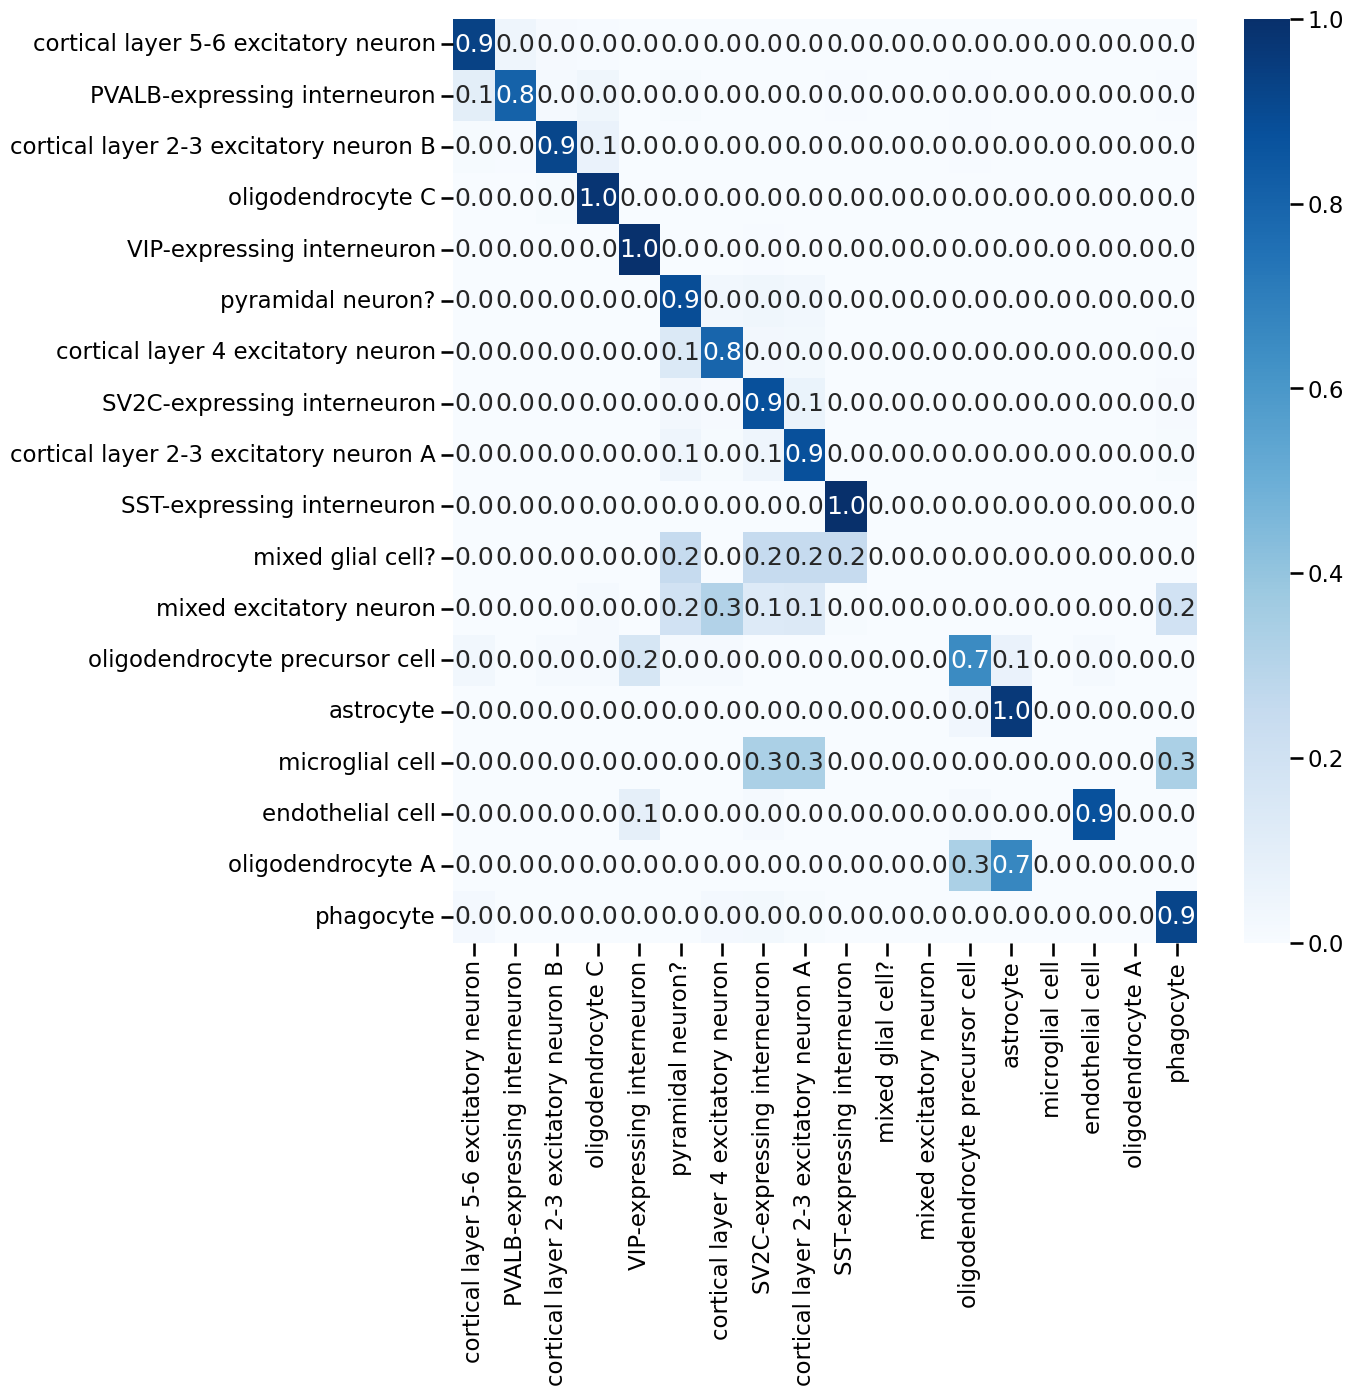

In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

set_predicted_cell_types = list(adata_unseen.obs["celltype"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)

cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

# Geneformer

As we did with scGPT earlier, we will set up the environment to use a GPU if available, configure the scGPT model, and process the data to obtain the embeddings. For Geneformer, we will need to do a few adjustments: it requires gene names as ensembl IDs `adata.var["ensembl_id"]`, and the number of counts `adata.var["n_counts"]`. Then, we'll train the model and compare their performance.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['cell_type'] = adata.obs['celltype']
adata.var["ensembl_id"] = adata.var["index_column"]

geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata, gene_names = "ensembl_id")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

2024-07-11, 12:34:53.132 helical.services.downloader INFO File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/gene_median_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-07-11, 12:34:53.132 helical.services.downloader INFO File saved to: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/gene_median_dictionary.pkl'
2024-07-11, 12:34:53.133 helical.services.downloader INFO File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-07-11, 12:34:53.133 helical.services.downloader INFO File saved to: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl'
2024-07-11, 12:34:53.134 helical.services.downloader INFO File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/token_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
2024-0

(7844, 512)

##### Training the model

In [21]:
head_model_geneformer = head_model
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_geneformer.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
111/111 [==============================] - 0s 2ms/step - loss: 2.9113 - f1_score: 0.0384 - val_loss: 2.0850 - val_f1_score: 0.0238
Epoch 2/50
111/111 [==============================] - 0s 1ms/step - loss: 2.1368 - f1_score: 0.0540 - val_loss: 1.9143 - val_f1_score: 0.1056
Epoch 3/50
111/111 [==============================] - 0s 1ms/step - loss: 1.9784 - f1_score: 0.1068 - val_loss: 1.7465 - val_f1_score: 0.1802
Epoch 4/50
111/111 [==============================] - 0s 1ms/step - loss: 1.8579 - f1_score: 0.1463 - val_loss: 1.6473 - val_f1_score: 0.1536
Epoch 5/50
111/111 [==============================] - 0s 1ms/step - loss: 1.7795 - f1_score: 0.1471 - val_loss: 1.6104 - val_f1_score: 0.1725
Epoch 6/50
111/111 [==============================] - 0s 1ms/step - loss: 1.7342 - f1_score: 0.1624 - val_loss: 1.5491 - val_f1_score: 0.1936
Epoch 7/50
111/111 [==============================] - 0s 1ms/step - loss: 1.6964 - f1_score: 0.1728 - val_loss: 1.5166 - val_f1_score: 0.1984
Epoch 

In [22]:
# %tensorboard --logdir logs/fit # uncomment to use tensorboard

##### Loading the unseen evaluation set

In [23]:
adata_unseen = sc.read("ms_default.h5ad")
adata_unseen.var["ensembl_id"] = adata_unseen.var["index_column"]
adata_unseen.obs['n_counts'] = adata_unseen.X.sum(axis=1)
adata_unseen.obs['cell_type'] = adata_unseen.obs['celltype']
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "ensembl_id")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer.predict(x_unseen_geneformer)

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/helical/models/geneformer/geneformer_tokenizer.py:366: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  filter_pass_loc = np.where(adata.obs.get("filter_pass", 0) == 1)[0]
2024-07-11, 13:42:22.463 helical.models.geneformer.geneformer_tokenizer INFO Anndata has no column attribute 'filter_pass'. Passing all cells for tokenization.
2024-07-11, 13:42:23.147 helical.models.geneformer.geneformer_tokenizer INFO Creating dataset.
Map: 100%|██████████| 7844/7844 [00:00<00:00, 10906.64 examples/s]
2024-07-11, 13:42:23.957 helical.models.geneformer.model INFO Inference started:
100%|██████████| 157/157 [43:33<00:00, 16.64s/it]

246/246 [==============================] - 0s 279us/step


In [24]:
y_true_unseen = np.array(adata_unseen.obs["celltype"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen_geneformer, axis=1)]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 58.5%
Evaluation set precision: 46.7%
Evaluation set f1: 45.5%
Evaluation set recall: 47.2%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Compare scGPT and Geneformer Performance

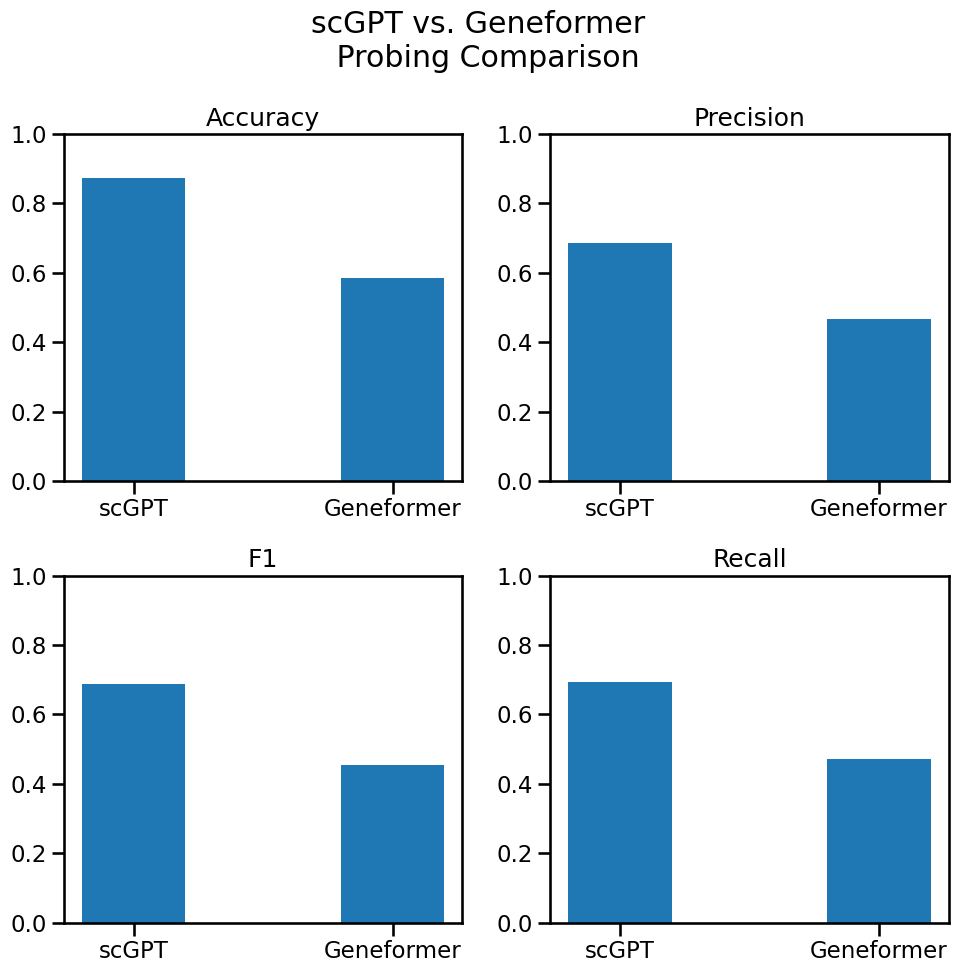

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()


We can see that the Geneformer clearly underperforms in all metrics. scGPT has similar results to what is reported in the [paper](https://www.biorxiv.org/content/10.1101/2023.10.24.563625v1.full.pdf). Keeping in mind, of course, that in that paper, the entire models were fine-tuned.

## scGPT
- Accuracy: 86.4%
- Precision: 81.1%
- Recall: 76.4%
- Macro F1: 75.3%

## Geneformer
- Accuracy: 73.1%
- Precision: 55.0%
- Recall: 58.7%
- Macro F1: 56.0%
